# Evaluating Trading Strategies with Python 101

## Setup

In [1]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import quantstats as qs

# api key
from api_keys import FMP_API_KEY

# plotting settings
plt.style.use("seaborn-v0_8")
plt.rcParams["figure.figsize"] = (16, 8)

In [2]:
%config InlineBackend.figure_format = "retina"

## Downloading data

In [3]:
SYMBOL = "AAPL"
START_DATE = "2021-01-01"

In [4]:
def get_price_data(symbol, start_date):
    hist_price_url = f"https://financialmodelingprep.com/api/v3/historical-price-full/{symbol}?from={start_date}&apikey={FMP_API_KEY}"
    r_json = requests.get(hist_price_url).json()
    df = pd.DataFrame(r_json["historical"]).set_index("date").sort_index()
    df.index = pd.to_datetime(df.index)
    return df

In [5]:
df = get_price_data(SYMBOL, START_DATE)
df

,open,high,low,close,adjClose,volume,unadjustedVolume,change,changePercent,vwap,label,changeOverTime
date,,,,,,,,,,,,
2021-01-04,133.52,133.61,126.76,129.41,127.00,143301900,143301900,-4.11,-3.08000,129.930,"January 04, 21",-0.030800
2021-01-05,128.89,131.74,128.43,131.01,128.57,97664900,97664900,2.12,1.64000,130.390,"January 05, 21",0.016400
2021-01-06,127.72,131.05,126.38,126.60,124.24,155088000,155088000,-1.12,-0.87692,128.010,"January 06, 21",-0.008769
2021-01-07,128.36,131.63,127.86,130.92,128.48,109578200,109578200,2.56,1.99000,130.140,"January 07, 21",0.019900
2021-01-08,132.43,132.63,130.23,132.05,129.59,105158200,105158200,-0.38,-0.28694,131.640,"January 08, 21",-0.002869
...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-12,174.26,178.36,174.21,176.55,176.55,101670886,101670886,2.29,1.31000,175.845,"April 12, 24",0.013100
2024-04-15,175.36,176.63,172.50,172.69,172.69,73531773,73531773,-2.67,-1.52000,174.295,"April 15, 24",-0.015200
2024-04-16,171.75,173.76,168.27,169.38,169.38,73711235,73711235,-2.37,-1.38000,170.790,"April 16, 24",-0.013800


## Simple trading strategy

In [9]:
# keep only the adjusted close price
df = df[["adjClose"]]

# calculate log returns
df["log_rtn"] = df["adjClose"].apply(np.log).diff(1)

# calculate the 20-day SMA
df["sma_20"] = df["adjClose"].rolling(window=20).mean()

# determine the position
df["position"] = (df["adjClose"] > df["sma_20"]).astype(int)

# calculate the returns of the strategy
df["strategy_rtn"] = df["position"].shift(1) * df["log_rtn"]

df

/var/folders/jg/42cx8xxn6_s1kcdc594gmf_w0000gn/T/ipykernel_15195/1033170000.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["log_rtn"] = df["adjClose"].apply(np.log).diff(1)
/var/folders/jg/42cx8xxn6_s1kcdc594gmf_w0000gn/T/ipykernel_15195/1033170000.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["sma_20"] = df["adjClose"].rolling(window=20).mean()


,adjClose,log_rtn,sma_20,position,strategy_rtn
date,,,,,
2021-01-04,127.00,NaN,NaN,0,NaN
2021-01-05,128.57,0.012286,NaN,0,0.000000
2021-01-06,124.24,-0.034258,NaN,0,-0.000000
2021-01-07,128.48,0.033558,NaN,0,0.000000
2021-01-08,129.59,0.008602,NaN,0,0.000000
...,...,...,...,...,...
2024-04-12,176.55,0.008590,171.7250,1,0.008590
2024-04-15,172.69,-0.022106,171.7285,1,-0.022106
2024-04-16,169.38,-0.019353,171.5115,0,-0.019353


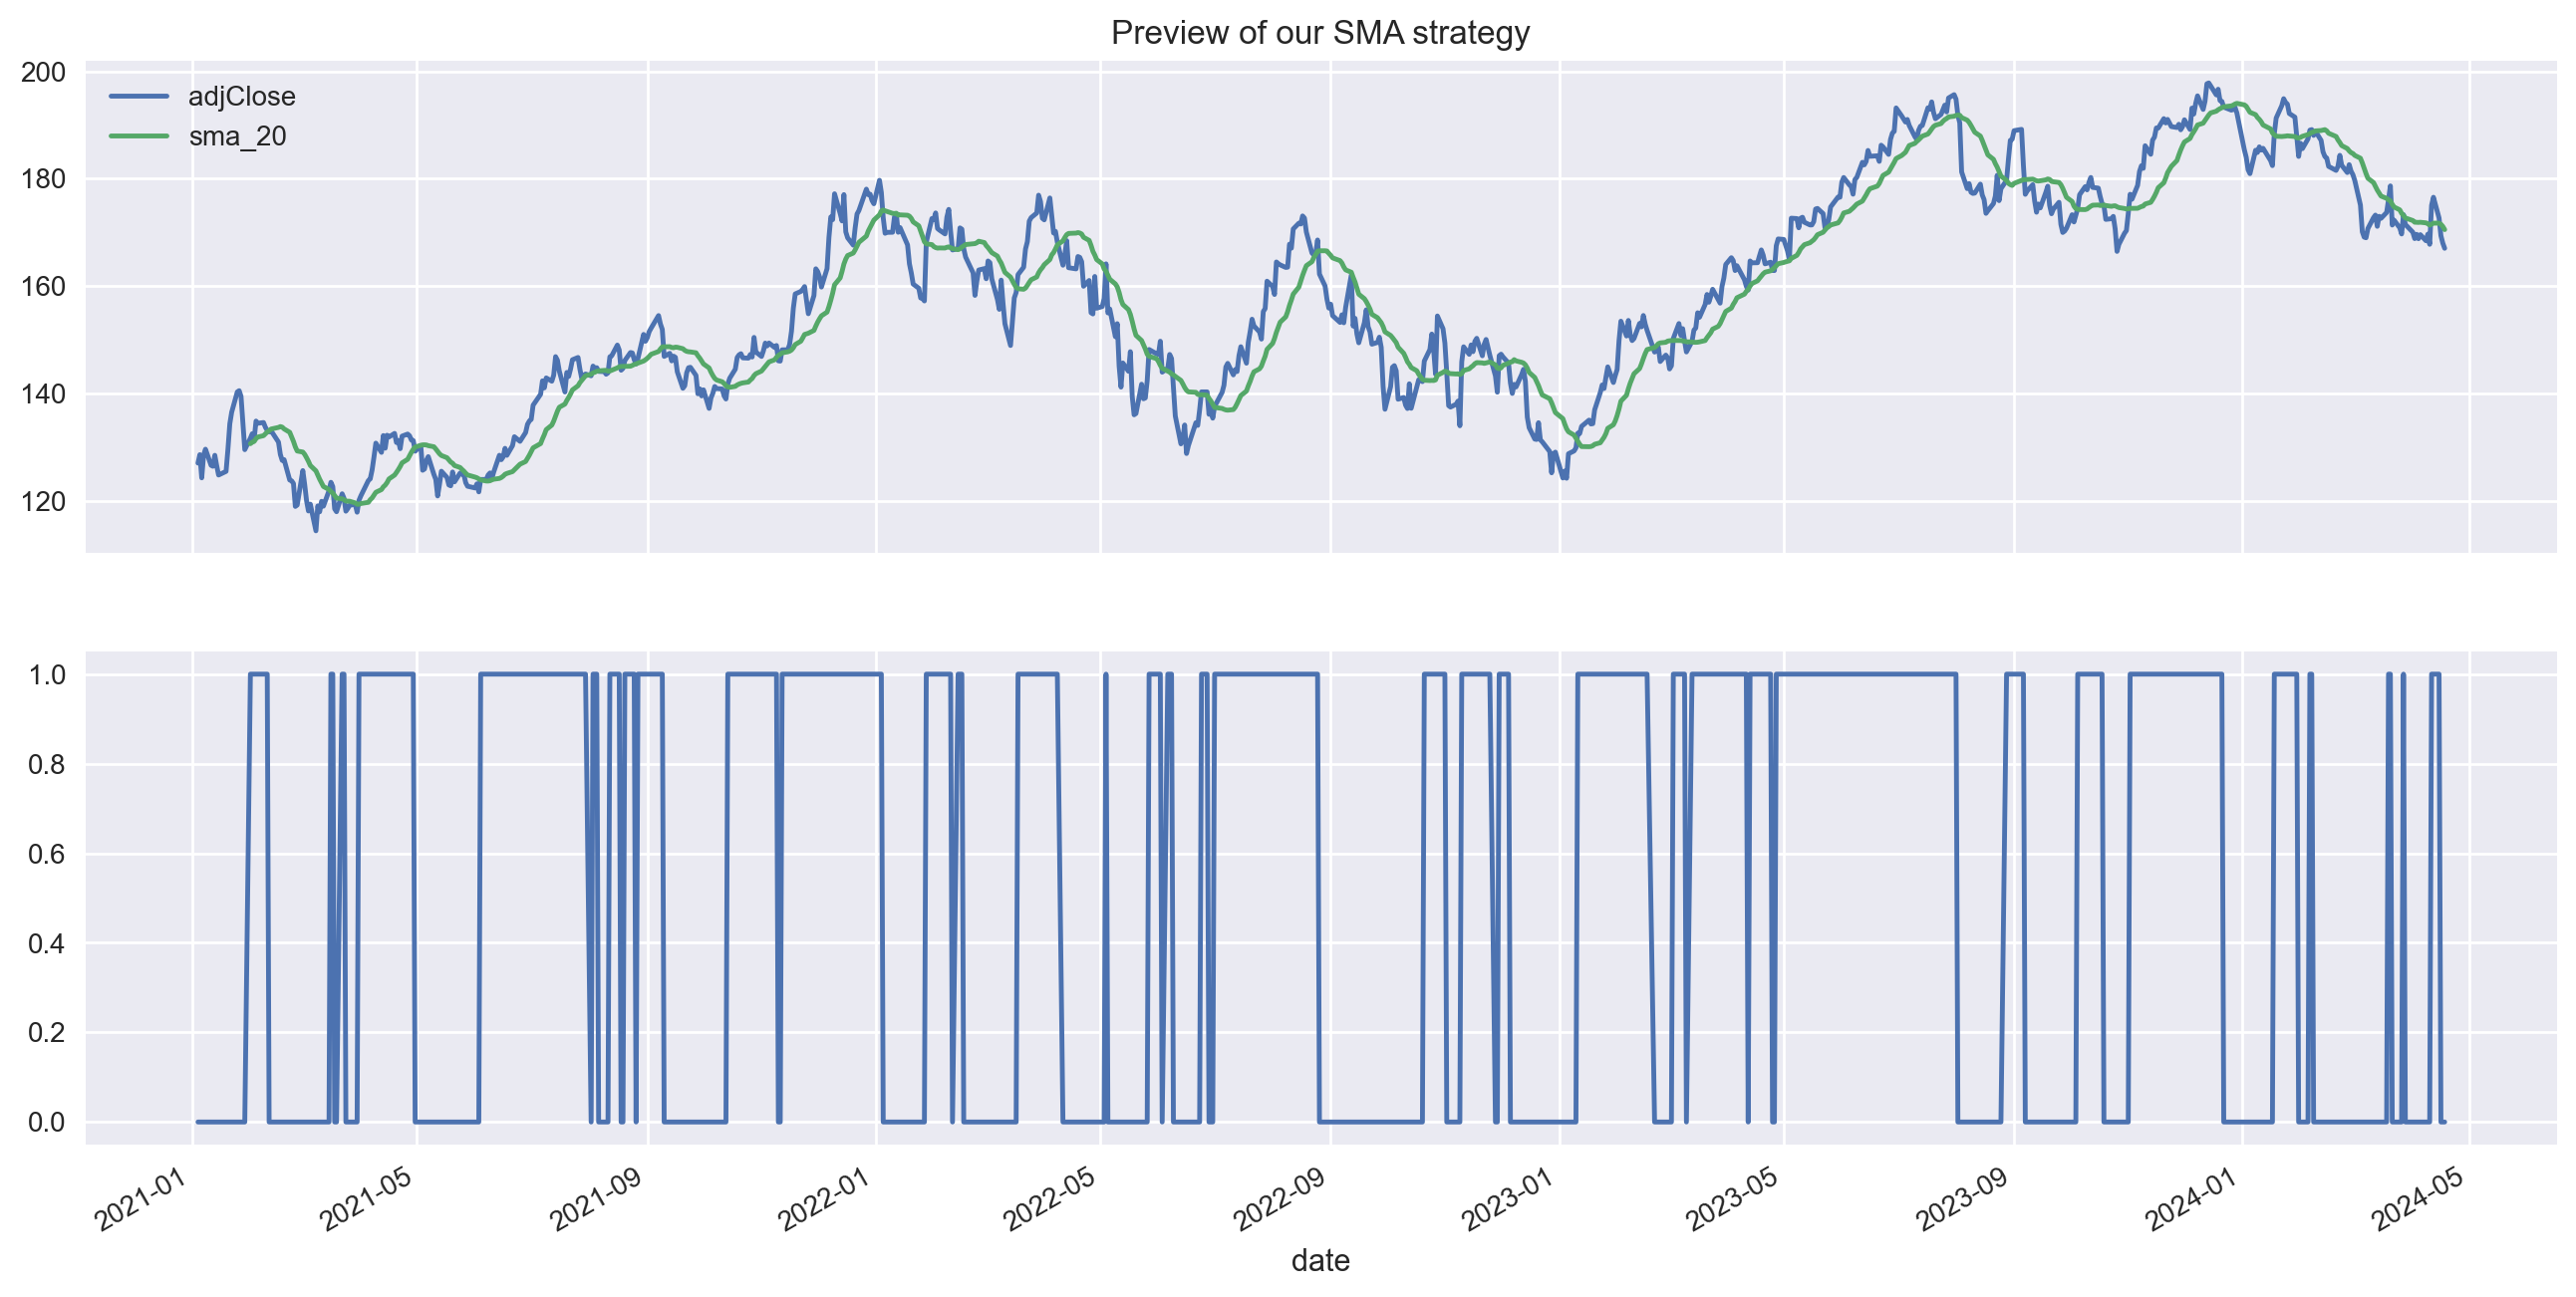

In [8]:
fig, ax = plt.subplots(2, sharex=True)
df.loc[:, ["adjClose", "sma_20"]].plot(ax=ax[0])
df.loc[:, "position"].plot(ax=ax[1])
ax[0].set_title("Preview of our SMA strategy");

## Evaluating the strategy's performance

In [10]:
qs.reports.metrics(df["strategy_rtn"], benchmark="AAPL", mode="basic")

[*********************100%%**********************]  1 of 1 completed

                    Benchmark (AAPL)    Strategy
------------------  ------------------  ----------
Start Period        2021-01-05          2021-01-05
End Period          2024-04-18          2024-04-18
Risk-Free Rate      0.0%                0.0%
Time in Market      98.0%               54.0%

Cumulative Return   24.53%              61.71%
CAGR﹪              4.72%               10.63%

Sharpe              0.38                0.93
Prob. Sharpe Ratio  75.65%              95.46%
Sortino             0.56                1.39
Sortino/√2          0.39                0.99
Omega               1.24                1.24

Max Drawdown        -31.31%             -19.95%
Longest DD Days     522                 169

Gain/Pain Ratio     0.07                0.24
Gain/Pain (1M)      0.31                0.85

Payoff Ratio        1.15                1.13
Profit Factor       1.07                1.24
Common Sense Ratio  1.03                1.34
CPC Index           0.62                0.73
Tail Ratio          


/Users/eryk/Documents/eryk/medium_articles/medium_articles_2024/lib/python3.11/site-packages/quantstats/stats.py:510: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  returns = _utils._prepare_returns(returns, rf).resample(resolution).sum()


In [ ]:
qs.reports.html(df["strategy_rtn"], benchmark="AAPL")